In [1]:
import numpy as np
from scipy import linalg
from scipy.linalg import norm
from scipy.spatial import distance
import math
import cmath
import matplotlib.pyplot as plt

$ \underset{W \in \mathbb{R}^{d \times k}:W^\top W=I}{\max}\frac{1}{n}\|X^\top W\|_F^2$

## VR-PCA, k = 1 case

In [3]:
d = 100
n = 500
eigen_gap_array = [0.16, 0.05, 0.016, 0.005, 0.0016]
num_loop = 60

$D_{d\times d}$ is diagonal with diagonal entries as  
$(1,1-\lambda,1-1.1\lambda,...,1-1.4\lambda,q_1,q_2,...)$ where $q_i=|g_i|/d$ and each $g_i$ is from standard Gaussian distribution;  
$X=UDV^T$, where $U_{d\times d}, V_{n\times d}$

In [39]:
def form_matrix(d, n, eigen_gap):
    D1 = np.array([1.0])
    D2 = 1-np.linspace(1,1.4,5)*eigen_gap
    D3 = abs(np.random.randn(d-6))/d  
    D = np.diag(np.concatenate((D1,D2,D3)))
    
    U = linalg.orth(np.random.rand(d,d))
    V = linalg.orth(np.random.rand(n,d))
    X = U.dot(D).dot(V.T)

    first_left_eigen_vec = U[:,0].reshape(d,1)

    noise = np.random.rand(d,1) * 1 * max(V[0,:])
    
    w_tidle_0 = first_left_eigen_vec + noise
    w_tidle_0 = w_tidle_0 / norm(w_tidle_0, 2)
    
    return [X, first_left_eigen_vec, w_tidle_0]

**Parameters:** step size $\eta$, epoch length $m$  
**Input:** Data matrix $X=(x_1, ..., x_n)$; Initial unit vector $\tilde{w}_0$  
**for** $s=1,2,...$ **do**  
&emsp;$\tilde{u} = \frac{1}{n}\Sigma x_i(x_i^T \tilde{w}_{s-1})$  
&emsp;$w_0 = \tilde{w}_{s-1}$  
&emsp;**for** $t = 1,2,...,m$ **do**   
&emsp;&emsp;Pick $i_t \in \{1,...,n\}$ uniformly  
&emsp;&emsp;$w'_t = w_{t-1}+\eta (x_{i_t}(x^T_{i_t}w_{t-1}-x^T_{i_t}\tilde{w}_{s-1}) + \tilde{u})$  
&emsp;&emsp;$w_t = \frac{1}{||w'_t||}w'_t$  
&emsp;**end for**  
&emsp;$\tilde{w_s} = w_m$  
**end for**

$m = n$

$\eta = \frac{1}{\bar r \sqrt{n}}$, $\bar r = \frac{1}{n}\Sigma\|x_i\|^2$  

$error = 1-\frac{\|X^Tw\|^2}{max_{v:\|v\|=1}\|X^Tv\|^2}$

In [58]:
def VRPCA(X, w_tidle_0, first_left_eigen_vec, d, n, num_loop):
    error = [None] * num_loop
    
    # norm(X, 'fro') in MATLAB is same as norm(X) in python
    r_bar = 1/n * pow(norm(X), 2)
    eta = 1/(r_bar * math.sqrt(n))
    m = n
    A = (1/n * X).dot(X.T)
    
    for s in range(1,num_loop+1):
        if s == 1:
            w_tidle_s1 = w_tidle_0
        else:
            w_tidle_s1 = w_tidle_s
        
        u_tidle = A.dot(w_tidle_s1)
        w_0 = w_tidle_s1
        
        for t in range(1,m+1):
            if t == 1:
                w_t1 = w_0
            else:
                w_t1 = w_t
            i_t = np.random.permutation(n)
            temp = X[:,i_t].T.dot(w_t1) - X[:,i_t].T.dot(w_tidle_s1)
            w_t_prime = w_t1 + eta * (X[:,i_t].dot(temp) + u_tidle)
            w_t = 1/norm(w_t_prime, 2) * w_t_prime
            
        w_tidle_s = w_t
        
        top = norm(X.T.dot(w_tidle_s),2) ** 2
        bottom = norm(X.T.dot(first_left_eigen_vec),2) ** 2
        error[s-1] = np.real(cmath.log10(1-top/bottom))
    return error

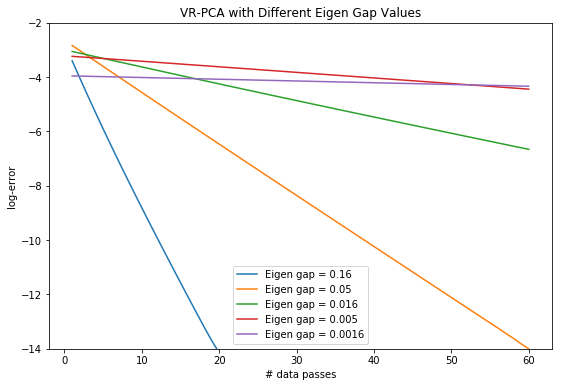

In [6]:
plt.figure(figsize = (9,6))
while True:
    try:
        for i in range(len(eigen_gap_array)):
            eigen_gap = eigen_gap_array[i]
            [X, first_left_eigen_vec, w_tidle_0] = form_matrix(d,n,eigen_gap)
            error = VRPCA(X, w_tidle_0, first_left_eigen_vec, d, n, num_loop)
            xlim = [x for x in range(1,num_loop+1)]
            plt.plot(xlim, error, label = 'Eigen gap = {}'.format(eigen_gap))
            plt.legend()
        plt.xlabel('# data passes')
        plt.ylabel('log-error')
        plt.title('VR-PCA with Different Eigen Gap Values')
        plt.ylim(-14,-2)
        plt.show()
        break
    except ValueError:
        continue
    else:
        print("Other Errors")

## VR-PCA, k > 1 cases

https://math.stackexchange.com/questions/768882/power-method-for-finding-all-eigenvectors


In [152]:
def orthonormalization(M):
    row, col = M.shape
    
    U = np.zeros([row,col])
    U[:,0] = M[:,0]/norm(M[:,0],2)
    
    for i in range(1,col):
        U[:,i] = M[:,i]
        for j in range(i):
            U[:,i] = U[:,i] - U[:,j].T.dot(U[:,i])/(norm(U[:,j],2))**2 * U[:,j]
        U[:,i] = U[:,i]/norm(U[:,i],2)
    return U

http://mlwiki.org/index.php/Power_Iteration  Power Iteration

In [153]:
def eigenvalue(A,v):
    Av = A.dot(v)
    return v.dot(Av)

In [154]:
def power_iteration(A):
    n,d = A.shape
    v = np.ones(d)/np.sqrt(d)
    
    ev = eigenvalue(A, v)

    while True:
        Av = A.dot(v)
        v_new = Av/np.linalg.norm(Av)
        
        ev_new = eigenvalue(A, v_new)
        if np.abs(ev - ev_new) < 0.01:
            break
        
        v = v_new
        ev = ev_new
    return ev_new, v_new

$D_{d\times d}$ is diagonal with diagonal entries as  
$(1,1-\lambda,1-1.1\lambda,...,1-1.4\lambda,q_1,q_2,...)$ where $q_i=|g_i|/d$ and each $g_i$ is from standard Gaussian distribution;  
$X=UDV^T$, where $U_{d\times d}, V_{n\times d}$

In [155]:
def form_matrix(d, n, eigen_gap, k):
    D1 = np.array([1.0])
    D2 = 1-np.linspace(1,1.4,5)*eigen_gap
    D3 = abs(np.random.randn(d-6))/d
    D_temp = np.concatenate((D1,D2,D3))
    D = np.diag(D_temp)
    
    U = linalg.orth(np.random.rand(d,d))
    V = linalg.orth(np.random.rand(n,d))
    X = U.dot(D).dot(V.T)

    first_eigen_mat = U[:,0:k] 

    noise = np.random.rand(d,k) * 1 * max(V[0,:])
    
    W_tidle_0 = first_eigen_mat + noise
    W_tidle_0 = orthonormalization(W_tidle_0)

    return [X, first_eigen_mat, W_tidle_0]

**Parameters** Rank $k$, Step size $\eta$, epoch length $m$  
**Input** $X=(x_1, ..., x_n)$; Initial $d\times k$ matrix $\tilde{W_0}$  

**for** $s=1,2,...$ **do**  
&emsp;$\tilde{U} = \frac{1}{n}\Sigma x_i(x_i^T \tilde{W}_{s-1})$  
&emsp;$W_0 = \tilde{W}_{s-1}$  
&emsp;**for** $t = 1,2,...,m$ **do**  
&emsp;&emsp;$B_{t-1} = VU^T$, where $USV^T$ is SVD decomp of $W^T_{t-1} \tilde{W}_{s-1}$  
&emsp;&emsp;Pick $i_t \in \{1,...,n\}$ uniformly  
&emsp;&emsp;$W'_t = W_{t-1}+\eta (x_{i_t}(x^T_{i_t}W_{t-1}-x^T_{i_t}\tilde{W}_{s-1}B_{t-1}) + \tilde{U}B_{t-1})$  
&emsp;&emsp;$W_t = W'_t(W'^T_t W'_t)^{-1/2}$  
&emsp;**end for**  
&emsp;$\tilde{W_s} = W_m$  
**end for**

$m = n$  
$\eta = \frac{1}{\bar r \sqrt{n}}$, $\bar r = \frac{1}{n}\Sigma\|x_i\|^2$  
$error = 1-\frac{\|X^TW\|^2_F}{max_{V:V^TV=I}\|X^TV\|^2_F}$

#### The way to find $A^{-1/2}$ for a matrix: 

$A_{n\times n} = VDV^{-1}$ <b>(eigendecomposition)</b>, then square roots of $A$ is $VD^{1/2}V^{-1}$

https://math.stackexchange.com/questions/1311972/interpreting-negative-square-root-of-a-matrix  
https://en.wikipedia.org/wiki/Square_root_of_a_matrix  
https://en.wikipedia.org/wiki/Diagonalizable_matrix

In [156]:
def inverse_sqrt(M):
    eigenval, eigenvec = linalg.eig(M)    
    eval2 = np.real(eigenval) ** (-0.5)

    V = eigenvec
    D = np.diag(eval2)
    sqRt = V.dot(D).dot(linalg.inv(V)) 
    return sqRt

https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem  for calculating $B_{t-1}$

In [163]:
def VRPCA(X, W_tidle_0, first_eigen_mat, d, n, k, num_loop):
    error = [None] * num_loop
    r_bar = 1/n * pow(norm(X), 2)
    eta = 1/(r_bar * math.sqrt(n))
    m = n
    A = (1/n * X).dot(X.T)
    
    for s in range(1, num_loop + 1):
        if s == 1:
            W_tidle_s1 = W_tidle_0
        else:
            W_tidle_s1 = W_tidle_s
                
        U_tidle = A.dot(W_tidle_s1)
        W_0 = W_tidle_s1
                
        for t in range(1, m+1):
            if t == 1:
                W_t1 = W_0
            else:
                W_t1 = W_t
            
            decomp = W_t1.T.dot(W_tidle_s1) 
            U, S, Vh = linalg.svd(decomp)
            B_t1 = Vh.T.dot(U.T)  
            
            i_t = np.random.permutation(n)
        
            temp = X[:,i_t].T.dot(W_t1) - X[:,i_t].T.dot(W_tidle_s1)#.dot(B_t1) 
            W_t_prime = W_t1 + eta * (X[:,i_t].dot(temp) + U_tidle)#.dot(B_t1))
            
            temp2 = inverse_sqrt(W_t_prime.T.dot(W_t_prime))
            W_t = W_t_prime.dot(temp2)
            
        W_tidle_s = W_t
        
        top = pow(norm(X.T.dot(W_tidle_s)), 2)
        bottom = pow(norm(X.T.dot(first_eigen_mat)), 2)
        
        error[s-1] = np.real(cmath.log10(1-top/bottom))
    return error

In [158]:
d = 50
n = 250
eigen_gap_array = [0.16, 0.05, 0.016, 0.005, 0.0016]
num_loop = 60

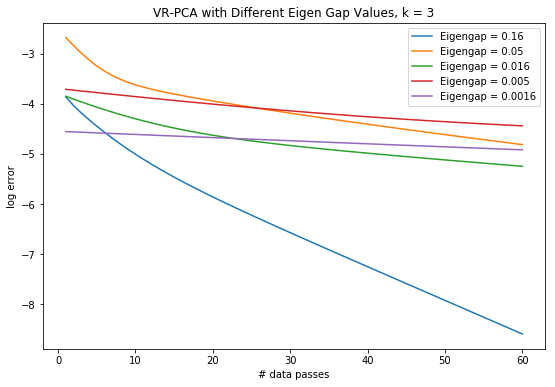

In [164]:
plt.figure(figsize = (9,6))
while True:
    try:
        for i in range(len(eigen_gap_array)):
            eigen_gap = eigen_gap_array[i]

            [X, first_eigen_mat, W_tidle_0] = form_matrix(d,n,eigen_gap,3)
            error = VRPCA(X, W_tidle_0, first_eigen_mat, d, n, 3, num_loop)
            xlim = [x for x in range(1,num_loop+1)]
            plt.plot(xlim, error, label = 'Eigengap = {}'.format(eigen_gap))
            plt.legend()

        plt.xlabel('# data passes')
        plt.ylabel('log error')
        plt.title('VR-PCA with Different Eigen Gap Values, k = 3')
        #plt.ylim(-8, -3)
        plt.show()
        break
    except ValueError:
        continue
    else:
        print("Other Errors")

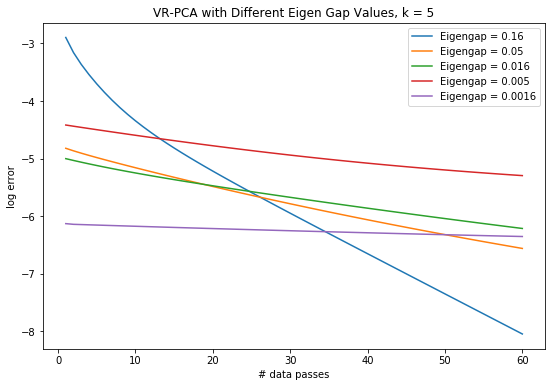

In [165]:
plt.figure(figsize = (9,6))
while True:
    try:
        for i in range(len(eigen_gap_array)):
            eigen_gap = eigen_gap_array[i]

            [X, first_eigen_mat, W_tidle_0] = form_matrix(d,n,eigen_gap,5)
            error = VRPCA(X, W_tidle_0, first_eigen_mat, d, n, 5, num_loop)
            xlim = [x for x in range(1,num_loop+1)]
            plt.plot(xlim, error, label = 'Eigengap = {}'.format(eigen_gap))
            plt.legend()

        plt.xlabel('# data passes')
        plt.ylabel('log error')
        plt.title('VR-PCA with Different Eigen Gap Values, k = 5')
#        plt.ylim(-10,-2)
        plt.show()
        break
    except ValueError:
        continue